In [3]:
import random
from functools import partial
import numpy as np
import pandas as pd
import sys, os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import fitstools
from pathlib import PurePath
import glob
from balltracking import mballtrack as mblt

import plotly.express as px
import plotly.graph_objects as go

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
DTYPE = np.float32

%matplotlib widget

ModuleNotFoundError: No module named 'fitsio'

In [4]:
def prep_data(image):
    image2 =np.abs(image)
    image3 = image2.max() - image2
    surface = (image3 - image3.mean())/image3.std()
    return surface.copy(order='C').astype(DTYPE)

In [5]:
# Data prepped by COR2_tracking_prep.ipynb
datadir = PurePath('C:\Data\STEREO\L7tum\prep_fits')
outputdir = PurePath('C:\Data\STEREO\L7tum\\figures')
datafiles = sorted(glob.glob(str(PurePath(datadir, '*.fits'))))
nfiles = len(datafiles)
nframes = 10
fov = np.s_[0:659, 0:600]

mbt_dict = {"nt": nframes,
            "rs": 4,
            "am": 1,
            "dp": 0.3,
            "tdx": 1,
            "tdy": 100,
            "zdamping": 1,
            "ballspacing": 15,
            "intsteps": 20,
            "mag_thresh": 3.5,
            "noise_level": 2,
            "track_emergence": False,
            "prep_function": prep_data,
            "datafiles": datafiles,
            "fov": fov,
            "do_plots": False,
            "astropy": True,
            "verbose": False,
            "outputdir": datadir,
            "fig_dir": PurePath(datadir, 'figures')}

mbt = mblt.MBT(polarity=1, **mbt_dict)

nballs_max = 197700


(0.0, 659.0)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
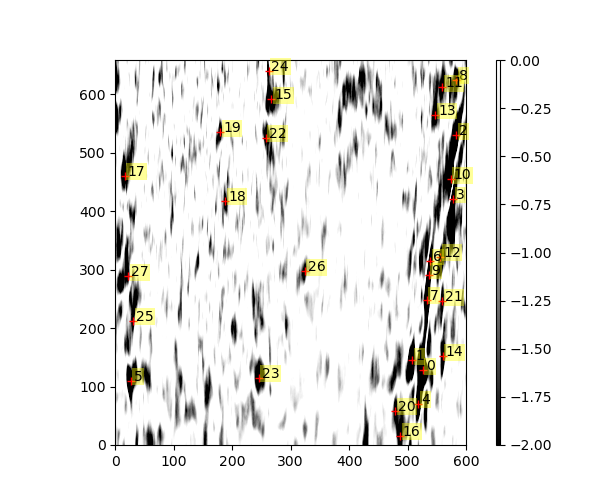

In [15]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(6,5))
im = axs.imshow(mbt.surface, vmin = -2, vmax=0, origin='lower', cmap='Greys_r')
# position for the colorbar
divider = make_axes_locatable(axs)
cax = divider.append_axes('right', size='1%', pad=0.3)
# Adding the colorbar
cbar = plt.colorbar(im, cax = cax)

axs.plot(mbt.xstart, mbt.ystart, 'r+')
labels = np.arange(0, mbt.nballs)
labels_str = [str(l) for l in labels]
for i, l in enumerate(labels_str):
    axs.text(mbt.xstart[i]+5, mbt.ystart[i], l, color='black', fontsize=10, bbox=dict(facecolor='yellow', alpha=0.4, edgecolor='none', pad=1))

axs.set_xlim([0, 600])
axs.set_ylim([0, 659])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
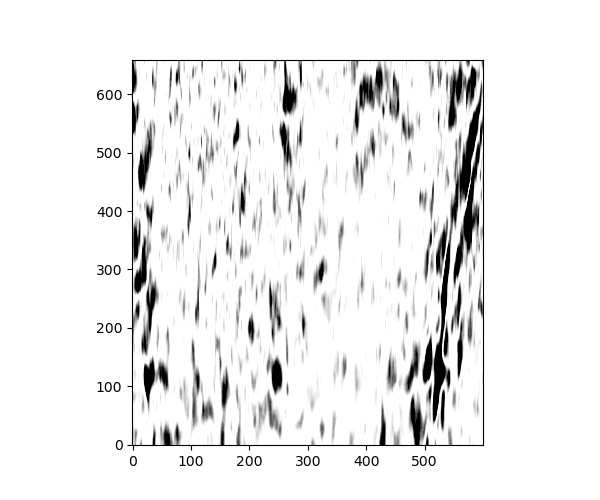

In [16]:
n = 0
image = fitstools.fitsread(
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(6,5))
im = axs.imshow(mbt.surface, vmin = -2, vmax=0, origin='lower', cmap='Greys_r')

In [ ]:
# Get some data into a dataframe
x1 = list(range(0, 10))
y1 = random.sample(range(0, 10), 10)
# Prepare an output dataframe that will contain the labels (initially, there is none)
df = pd.DataFrame({'x':x1, 'y':y1, 'label': 'no label'})
df.set_index('x', inplace=True)

In [ ]:
samples = [np.abs(fitstools.fitsread(datafiles[i], cube=False, astropy=True))[fov] for i in range(nframes)]

In [ ]:
# Given (x,y), define a small local grid to search for local max. 
x = 100
y = 100
x = np.arange(-8, 8) + x
y = np.arange(-15, 15) + y
xx, yy = np.meshgrid(x, y)

In [ ]:
# Define the app. The "doc" argument is the container of your app. We add to it the graphs and GUI elements
def bkapp(doc):
    # Define the tools that will appear in the figure toolbar. 
    # The selection tool is necessary, e.g. `box_select`.
    TOOLTIPS = [
        ("x", "$x"),
        ("y", "$y"),
        ("value", "@image"),
    ]
    # tools = ['box_select', 'hover', 'reset']
    tools = ['hover', 'reset']
    # Create the figure axis
    fig = figure(x_axis_label='X [px]',
               y_axis_label='Y [px]',
               title="Test displaying image series",
               tooltips=TOOLTIPS,
               tools=tools)
    
    
    fig.x_range.range_padding = fig.y_range.range_padding = 0
    # Display the image
    color_mapper = LinearColorMapper(palette=palettes.Greys256[::-1], low=0, high=4)
    source = ColumnDataSource({'image': [samples[0]]})
    # im = p.image(image=[samples[0]], x=0, y=0, dw=600, dh=659, color_mapper=color_mapper)
    im = fig.image(source=source, x=0, y=0, dw=600, dh=659, color_mapper=color_mapper)

    myslider = Slider(title="Frame #", value=0, start=0, end=10, step=1)
    
    def callback(attr, old, new):
        frame_nb = myslider.value
        print(frame_nb) # same as `new`
        source.data.update({"image": [samples[frame_nb]]})

    # scatter.data_source.selected.on_change('indices', callback1)
    myslider.on_change('value_throttled', callback)
    
    
    # Add our GUI and graph in a column layout
    doc.add_root(column(myslider, fig))

In [ ]:
show(bkapp)

### Test Blob detection for more automated way of finding local max

In [ ]:
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

In [ ]:
blobs = blob_log(samples[0], max_sigma=30, num_sigma=10, threshold=1)

In [ ]:
sample = samples[0]
fig = plt.figure(figsize=(10,10))
plt.imshow(sample, origin='lower', vmin=0, vmax=4, cmap='Greys')
plt.plot(blobs[:,1], blobs[:,0], 'r+')
plt.plot(xx.ravel(), yy.ravel(), 'g+', alpha=0.1)